<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/Spectral_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/Reflectance_estimation/"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat

[[2.57305181 0.51792641]
 [1.13601661 2.39969414]
 [0.42710168 1.39198265]]
[[429.42417463]
 [-38.92345389]]
a shape (2, 1)
eigen shape (2, 61)


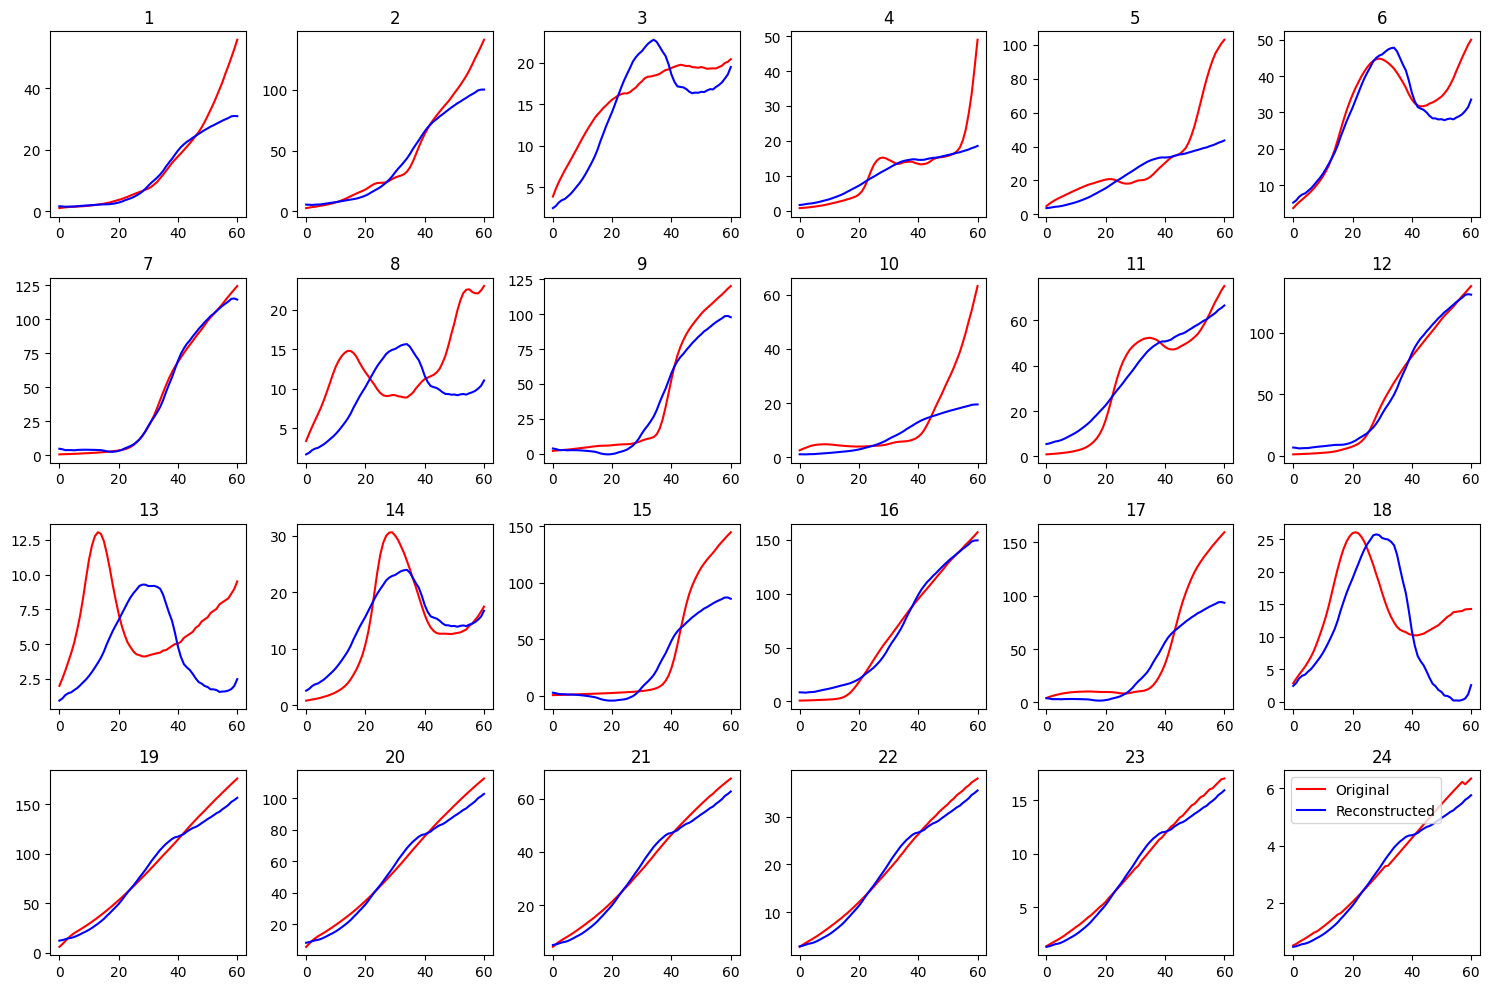

In [21]:
# Step 1a: Reading the light source and Munsell
P_lambda = pd.read_excel(file_path+'D65_and_A.xlsx', header=None).values
Lamda = np.arange(400, 705, 5)
interp_func = interp1d(P_lambda[:,0], P_lambda[:,1], fill_value="extrapolate")
P_lambda = interp_func(Lamda)

# Load Munsell reflectance data
munsell_data = loadmat(file_path+'munsell400_700_5.mat')
R_lambda = munsell_data['munsell']

# Step 1b: Getting the color signal
C_lambda = P_lambda[:, np.newaxis] * R_lambda


# Step 2: Computing eigenspectra of ensemble color signals
pca = PCA(n_components=2)
pca.fit(C_lambda.T)
eigen = pca.components_  # Get the first principal component


# Step 3: Computing transformation matrix T
data = np.loadtxt(file_path+'camera_8_spectra.txt')
Lambda_raw = data[:, 0]
S_R_raw = data[:, 1]
S_G_raw = data[:, 2]
S_B_raw = data[:, 3]

Lamda = np.arange(400, 705, 5)
S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(Lamda)
S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(Lamda)
S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(Lamda)
S_rgb = np.vstack((S_R, S_G, S_B)).T
T = S_rgb.T@ eigen.T
print(T)

# Step 4: Getting values of q
R_lambda_macbeth = pd.read_excel(file_path+'MacbethColorChecker.xlsx', header=None).values
range_mask = (R_lambda_macbeth[:, 0] > 399) & (R_lambda_macbeth[:, 0] < 701)
R_lambda_macbeth = R_lambda_macbeth[range_mask, :]
q_r, q_g, q_b = [], [], []

for i in range(1, 25):  # Index of Macbeth patches starts at i=2
    PRS_red = P_lambda * R_lambda_macbeth[:, i] * S_R
    q_r.append(np.sum(PRS_red))
    PRS_green = P_lambda * R_lambda_macbeth[:, i] * S_G
    q_g.append(np.sum(PRS_green))
    PRS_blue = P_lambda * R_lambda_macbeth[:, i] * S_B
    q_b.append(np.sum(PRS_blue))

# Applying the Wiener estimation
patch = 1
C1 = np.linalg.inv(T.T @ T)
C2 = C1 @ T.T
q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
a = C2 @ q
print(a)
print("a shape", a.shape)
print("eigen shape", eigen.shape)


# For all patches
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
for patch in range(24):
    C1 = np.linalg.inv(T.T @ T)
    C2 = C1 @ T.T
    q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
    a = C2 @ q
    color_spectra_macbeth = P_lambda * R_lambda_macbeth[:, patch + 1]
    C3 = eigen.T @ a

    axs[patch // 6, patch % 6].plot(color_spectra_macbeth, '-r', label='Original')
    axs[patch // 6, patch % 6].plot(C3, '-b', label='Reconstructed')
    axs[patch // 6, patch % 6].set_title(patch + 1)

plt.tight_layout()
plt.legend()
plt.show()

In [24]:
q_r[0]

323.85626264268586

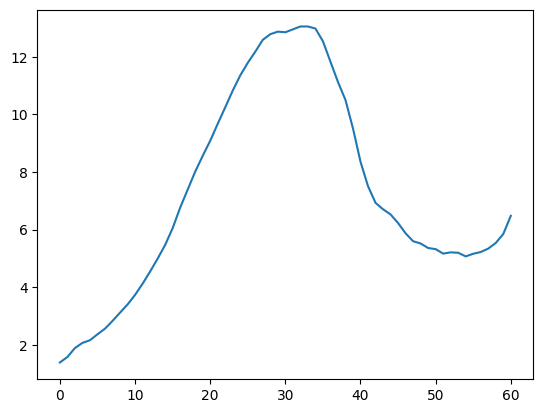

In [29]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.io import loadmat

def compute_reflectance(RGB, light_source_file, camera_sensitivity_file, munsell_file):
    # Step 1a: Reading the light source
    P_lambda = pd.read_excel(light_source_file, header=None).values
    Lamda = np.arange(400, 705, 5)
    interp_func = interp1d(P_lambda[:, 0], P_lambda[:, 1], fill_value="extrapolate")
    P_lambda = interp_func(Lamda)

    # Load Munsell reflectance data
    munsell_data = loadmat(munsell_file)
    R_lambda = munsell_data['munsell']

    # Step 1b: Getting the color signal
    C_lambda = P_lambda[:, np.newaxis] * R_lambda

    # Step 2: Computing eigenspectra of ensemble color signals
    pca = PCA(n_components=2)
    pca.fit(C_lambda.T)
    eigen = pca.components_

    # Step 3: Computing transformation matrix T
    data = np.loadtxt(camera_sensitivity_file)
    Lambda_raw = data[:, 0]
    S_R_raw = data[:, 1]
    S_G_raw = data[:, 2]
    S_B_raw = data[:, 3]

    S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(Lamda)
    S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(Lamda)
    S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(Lamda)
    S_rgb = np.vstack((S_R, S_G, S_B)).T
    T = S_rgb.T @ eigen.T

    # Step 4: Calculate q for RGB
    R_lambda_macbeth = pd.read_excel(macbeth_file, header=None).values
    range_mask = (R_lambda_macbeth[:, 0] > 399) & (R_lambda_macbeth[:, 0] < 701)
    R_lambda_macbeth = R_lambda_macbeth[range_mask, :]

    q_r, q_g, q_b = [], [], []

    for i in range(1, 25):
        PRS_red = P_lambda * R_lambda_macbeth[:, i] * S_R
        q_r.append(np.sum(PRS_red))
        PRS_green = P_lambda * R_lambda_macbeth[:, i] * S_G
        q_g.append(np.sum(PRS_green))
        PRS_blue = P_lambda * R_lambda_macbeth[:, i] * S_B
        q_b.append(np.sum(PRS_blue))

    # Wiener estimation for the given RGB
    C1 = np.linalg.inv(T.T @ T)
    C2 = C1 @ T.T
    q = np.vstack((RGB[0], RGB[1], RGB[2]))
    a = C2 @ q

    # Reflectance reconstruction
    reflectance = eigen.T @ a

    return reflectance

# Example usage
RGB = [150, 120, 130]  # Example RGB values
light_source_file = file_path+'D65_and_A.xlsx'
camera_sensitivity_file = file_path+'camera_8_spectra.txt'
munsell_file = file_path+'munsell400_700_5.mat'

reflectance = compute_reflectance(RGB, light_source_file, camera_sensitivity_file, munsell_file)
plt.plot(reflectance)


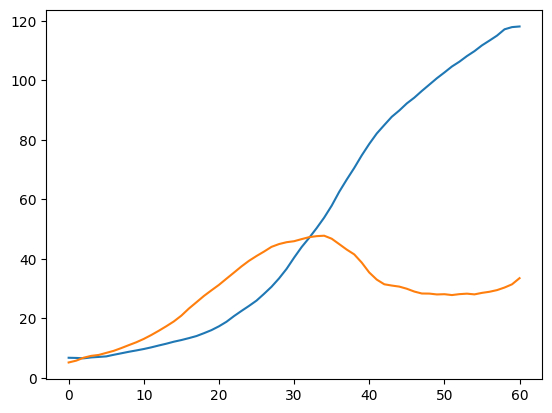

In [33]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat

class ReflectanceCalculator:
    def __init__(self, light_source_file, camera_sensitivity_file, munsell_file):
        # Load light source
        P_lambda_raw = pd.read_excel(light_source_file, header=None).values
        self.Lamda = np.arange(400, 705, 5)
        interp_func = interp1d(P_lambda_raw[:, 0], P_lambda_raw[:, 1], fill_value="extrapolate")
        self.P_lambda = interp_func(self.Lamda)

        # Load Munsell reflectance data
        munsell_data = loadmat(munsell_file)
        self.R_lambda = munsell_data['munsell']

        # Compute color signal
        self.C_lambda = self.P_lambda[:, np.newaxis] * self.R_lambda

        # Perform PCA once to compute the eigenspectra
        pca = PCA(n_components=2)
        pca.fit(self.C_lambda.T)
        self.eigen = pca.components_

        # Load camera sensitivity
        camera_data = np.loadtxt(camera_sensitivity_file)
        Lambda_raw = camera_data[:, 0]
        S_R_raw = camera_data[:, 1]
        S_G_raw = camera_data[:, 2]
        S_B_raw = camera_data[:, 3]

        S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(self.Lamda)
        S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(self.Lamda)
        S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(self.Lamda)
        self.S_rgb = np.vstack((S_R, S_G, S_B)).T

        # Compute transformation matrix T once
        self.T = self.S_rgb.T @ self.eigen.T

    def compute_reflectance(self, RGB):
        # Step 4: Calculate reflectance for given RGB using preloaded data
        C1 = np.linalg.inv(self.T.T @ self.T)
        C2 = C1 @ self.T.T
        q = np.vstack((RGB[0], RGB[1], RGB[2]))
        a = C2 @ q

        # Reconstruct reflectance
        reflectance = self.eigen.T @ a
        return reflectance

# Example usage
RGB = [q_r[19], q_g[10], q_b[10]]  # Example RGB values
light_source_file = file_path+'D65_and_A.xlsx'
camera_sensitivity_file = file_path+'camera_8_spectra.txt'
munsell_file = file_path+'munsell400_700_5.mat'
macbeth_file = file_path+'MacbethColorChecker.xlsx'

# Create an instance of the ReflectanceCalculator
calculator = ReflectanceCalculator(light_source_file, camera_sensitivity_file, munsell_file)

# Now, you can call the compute_reflectance function multiple times without reloading data
reflectance = calculator.compute_reflectance(RGB)
#print("Computed Reflectance:", reflectance)
plt.plot(reflectance)
# Call it again with different RGB
RGB2 = [q_r[5], q_g[5], q_b[5]]
reflectance2 = calculator.compute_reflectance(RGB2)
#print("Computed Reflectance for RGB2:", reflectance2)
plt.plot(reflectance2)